# **Import**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from IPython.display import Image
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout,Input, MaxPooling2D,RandomFlip, RandomRotation, RandomZoom, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix
import scipy.io
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import ResNet50
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToPILImage


## Preprocessing the dataset

In [ ]:
# Preprocessing function
def map_image(image, label):
    # Normalize the image
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0
    return image, label  # Return the preprocessed image and label

# Parameters
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

# Load and preprocess the CIFAR-10 training dataset
train_dataset = tfds.load('cifar10', as_supervised=True, split="train")

# Preprocess the dataset using the `map_image()` function
train_dataset = train_dataset.map(map_image)

# Shuffle and batch the dataset
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

# Load and preprocess the CIFAR-10 test dataset
test_dataset = tfds.load('cifar10', as_supervised=True, split="test")

# Preprocess the test dataset using the `map_image()` function
test_dataset = test_dataset.map(map_image)

# Batch the test dataset
test_dataset = test_dataset.batch(BATCH_SIZE)

# Count samples in train and test datasets
train_count = len(list(train_dataset))
test_count = len(list(test_dataset))

In [ ]:
# Load CIFAR10 dataset
train_dataset = tfds.load('cifar10', as_supervised=True, split="train")
test_dataset = tfds.load('cifar10', as_supervised=True, split="test")

# Count samples in train and test datasets
train_count = len(list(train_dataset))
test_count = len(list(test_dataset))

print(f"Number of training images: {train_count}")
print(f"Number of test images: {test_count}")


Number of training images: 50000
Number of test images: 10000


## **Formulate the problem:**
- **Input**:
  - Images: 32x32 RGB images (3 channels).
  - Shape: (32, 32, 3).

- **Output**:
  - Classes: One of 10 categories (airplane, automobile, ..., truck).
  - Output Format: A probability distribution over 10 classes.
  - Activation: The output layer uses a softmax activation function to produce class probabilities.

- **Objective**:
  - Minimize a suitable loss function for classification, such as categorical cross-entropy or sparse categorical cross-entropy.

- **Evaluation Metrics**:
  - Primary: Classification Accuracy.
  - Optional: Precision, Recall, F1-score, and Confusion Matrix to analyze per-class performance.

- Deep Learning Framework: TensorFlow, PyTorch (pre-trained model)

## **Data Augmnetation & Partitioning**

In [ ]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),           # Randomly flip images horizontally
    RandomRotation(0.1),                # Random rotation by ±10%
    RandomZoom(0.1)                     # Random zoom by ±10%
])

# Apply data augmentation during preprocessing
def augment_image(image, label):
    image = data_augmentation(image)    # Apply augmentation
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Apply to training dataset only
train_dataset = train_dataset.map(augment_image).shuffle(1024).batch(128)
test_dataset = test_dataset.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).batch(128)

In [ ]:
# Data Partitioning
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Print dataset shapes
print(f"Training Images Shape: {train_images.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")

Training Images Shape: (50000, 32, 32, 3)
Training Labels Shape: (50000, 1)
Test Images Shape: (10000, 32, 32, 3)
Test Labels Shape: (10000, 1)


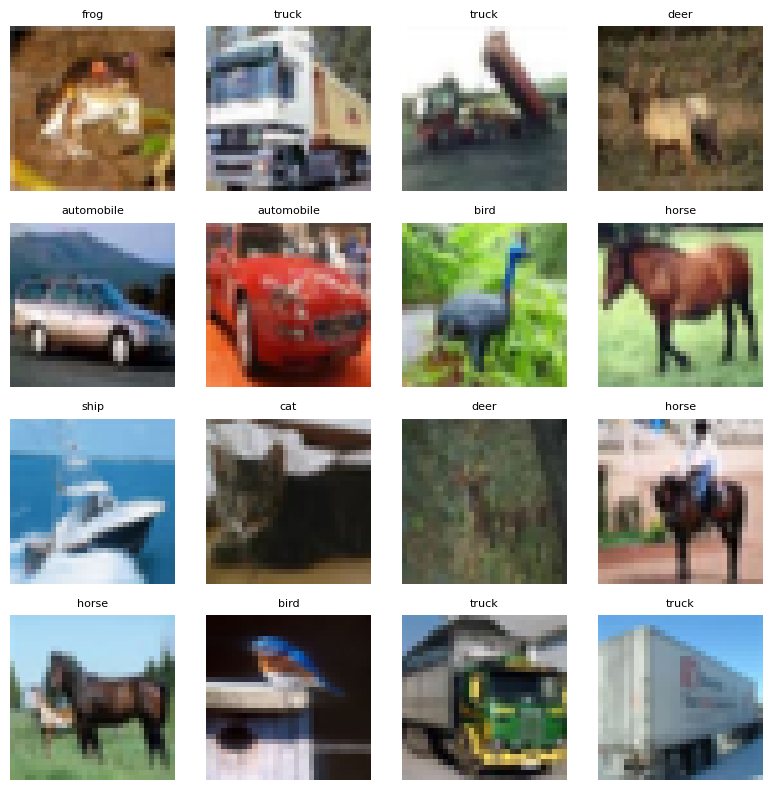

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize original images
plt.figure(figsize=(8, 8))
for i in range(16):  # Display 16 images
    plt.subplot(4, 4, i + 1)
    plt.imshow(train_images[i])  # Plot original training images

    # Extract the scalar value for the label
    label = train_labels[i][0] if len(train_labels[i]) > 0 else train_labels[i]

    # Set the title with class names
    plt.title(class_names[label], fontsize=8)  # Add class names
    plt.axis('off')  # Remove axes for better visuals

plt.tight_layout()
plt.suptitle("", fontsize=16)
plt.show()


Files already downloaded and verified


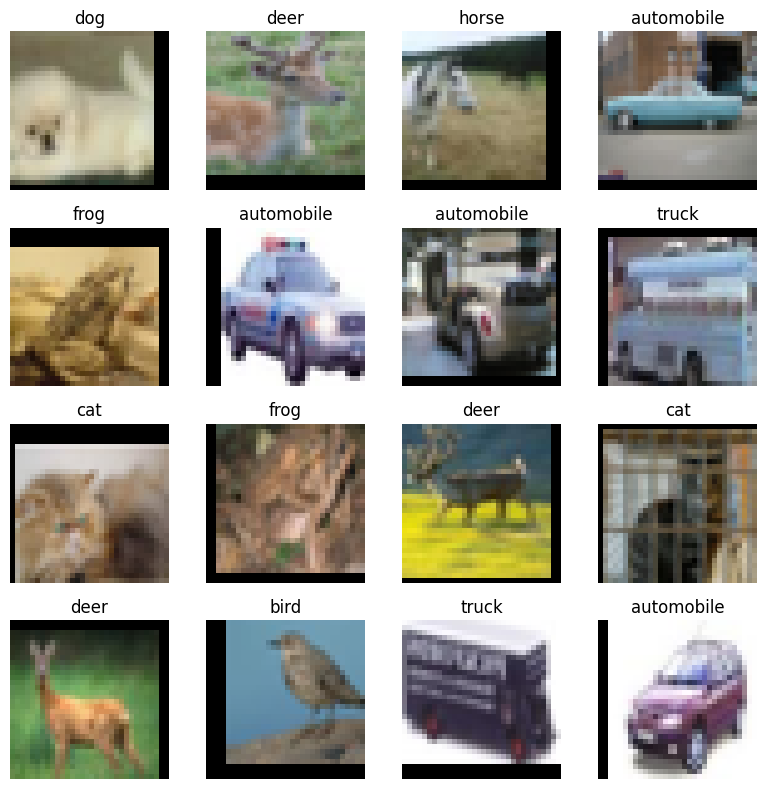

In [ ]:

# Define image transformations (augmentation and normalization)
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip images
    transforms.RandomCrop(32, padding=4),  # Randomly crop with padding
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize image to [-1, 1]
])

# Load CIFAR-10 training dataset
train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 transform=transform, download=True)

# Create DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Get a batch of augmented images
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Plot augmented images
plt.figure(figsize=(8, 8))
for i in range(16):  # Display 16 images
    plt.subplot(4, 4, i + 1)
    image = images[i].permute(1, 2, 0)  # Convert CHW to HWC format
    image = (image * 0.5 + 0.5).numpy()  # Denormalize the image
    plt.imshow(image)
    plt.title(class_names[labels[i].item()])  # Get class name for the label
    plt.axis('off')

plt.tight_layout()
plt.show()


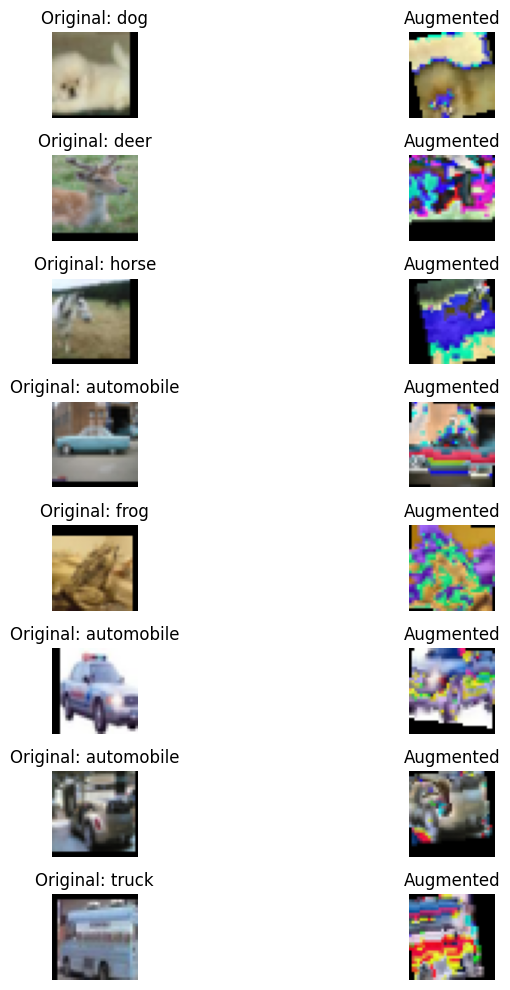

In [ ]:
# Define the augmentation pipeline with resizing
aug_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert tensor to PIL image
    transforms.Resize(40),  # Resize to a size larger than 32x32 to allow cropping
    transforms.RandomCrop(32, padding=4),  # Crop to 32x32 with padding
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomRotation(15),  # Random rotation
    transforms.ToTensor(),  # Convert back to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize
])

# Apply augmentations to the batch of images
aug_images = torch.stack([aug_transform(images[i]) for i in range(len(images))])  # Apply to each image in the batch

# Compare original vs augmented images
plt.figure(figsize=(10, 10))
for i in range(8):  # Display 8 pairs of original and augmented images
    # Original image
    plt.subplot(8, 2, 2 * i + 1)
    orig_image = images[i].permute(1, 2, 0)  # Convert CHW to HWC
    orig_image = (orig_image * 0.5 + 0.5).numpy()  # Denormalize
    plt.imshow(orig_image)
    plt.title(f"Original: {class_names[labels[i].item()]}")
    plt.axis('off')

    # Augmented image
    plt.subplot(8, 2, 2 * i + 2)
    aug_image = aug_images[i].permute(1, 2, 0)  # Convert CHW to HWC
    aug_image = (aug_image * 0.5 + 0.5).numpy()  # Denormalize
    plt.imshow(aug_image)
    plt.title(f"Augmented")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
# Split the training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42
)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

# Shuffle, batch, and prefetch datasets for efficient training
BATCH_SIZE = 128
train_dataset = train_dataset.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Verify dataset sizes
print(f"Train Dataset: {len(list(train_dataset))} batches")
print(f"Validation Dataset: {len(list(val_dataset))} batches")
print(f"Test Dataset: {len(list(test_dataset))} batches")

Train Dataset: 352 batches
Validation Dataset: 40 batches
Test Dataset: 79 batches


In [ ]:
# Split the training data into training and validation sets (90-10 split)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=42
)

# Print dataset shapes
print(f"New Training Images Shape: {train_images.shape}")
print(f"Validation Images Shape: {val_images.shape}")
print(f"Training Labels Shape: {train_labels.shape}")
print(f"Validation Labels Shape: {val_labels.shape}")

New Training Images Shape: (40500, 32, 32, 3)
Validation Images Shape: (4500, 32, 32, 3)
Training Labels Shape: (40500, 1)
Validation Labels Shape: (4500, 1)


In [ ]:
# Define the model
model = Sequential()

# Downsampling layers (Convolution + MaxPooling)
model.add(Conv2D(64, input_shape=(32, 32, 3), kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))

# Flatten and Dense layers for classification
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization
model.add(Dense(10, activation='softmax'))  # Output layer for 10 classes

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       2,097,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,469,386 (9.42 MB)

 Trainable params: 2,469,386 (9.42 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 336s 264ms/step - accuracy: 0.2946 - loss: 1.8877 - val_accuracy: 0.5402 - val_loss: 1.2808
Epoch 2/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 381s 264ms/step - accuracy: 0.5226 - loss: 1.3230 - val_accuracy: 0.6300 - val_loss: 1.0418
Epoch 3/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 331s 261ms/step - accuracy: 0.6072 - loss: 1.1160 - val_accuracy: 0.6750 - val_loss: 0.9398
Epoch 4/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 331s 261ms/step - accuracy: 0.6596 - loss: 0.9683 - val_accuracy: 0.7014 - val_loss: 0.8719
Epoch 5/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 382s 262ms/step - accuracy: 0.7075 - loss: 0.8301 - val_accuracy: 0.6857 - val_loss: 0.9109
Epoch 6/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 381s 261ms/step - accuracy: 0.7370 - loss: 0.7504 - val_accuracy: 0.7160 - val_loss: 0.8384
Epoch 7/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 382s 261ms/step - accuracy: 0.7683 - loss: 0.6632 - val_accuracy: 0.7334 - val_loss: 0.7784
Epoch 8/10
1266/1266 ━━━━━━━━━━━━━━━━━━━━ 383s 261ms/step - ac

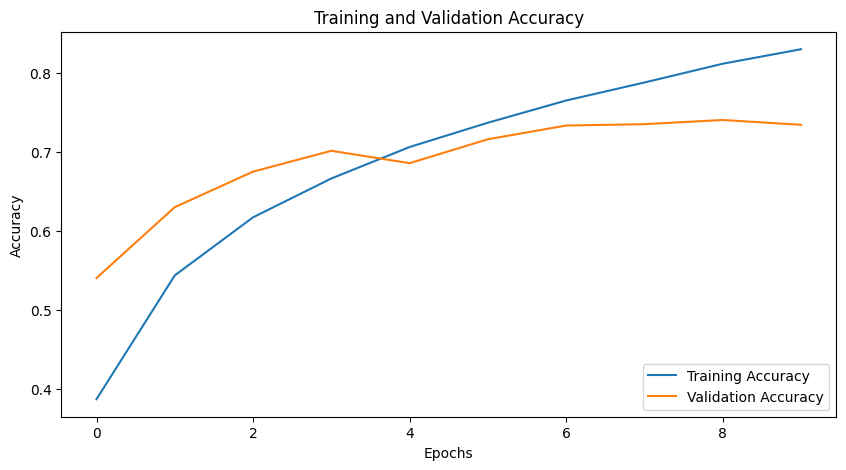

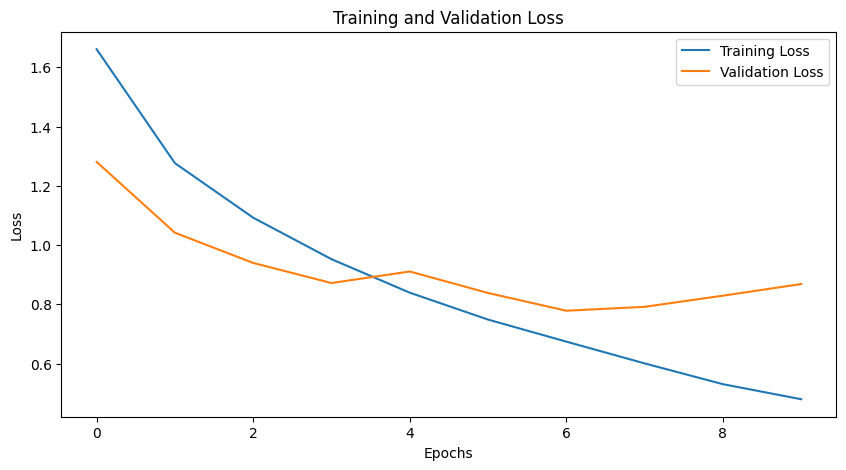

In [ ]:
## Train the model
history = model.fit(train_images, train_labels,
                    epochs=10,
                    validation_data=(test_images, test_labels))

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Evaluate the model on both training and test sets
train_loss, train_accuracy = model.evaluate(train_images, train_labels, verbose=2)
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=2)

print(f'Training Accuracy: {train_accuracy:.3f}')
print(f'Test Accuracy: {test_accuracy:.3f}')

1266/1266 - 79s - 63ms/step - accuracy: 0.9090 - loss: 0.2810
313/313 - 19s - 60ms/step - accuracy: 0.7343 - loss: 0.8685
Training Accuracy: 0.909
Test Accuracy: 0.734


79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step
Confusion Matrix:
[[805  10  36  17   7   4   1  15  62  43]
 [ 18 861   3   7   1   2   3   4  11  90]
 [ 90   5 616  60  91  65  19  35  11   8]
 [ 29  12  65 517  64 209  26  55  15   8]
 [ 32   5  63  40 695  30   9 118   7   1]
 [ 11   5  34 136  47 684   5  63   6   9]
 [ 10   6  52 117  85  37 656  13  11  13]
 [ 13   2  35  18  36  45   1 834   1  15]
 [ 64  31   6  12   6   5   2   5 836  33]
 [ 23  84   5  16   2   3   1  16  11 839]]


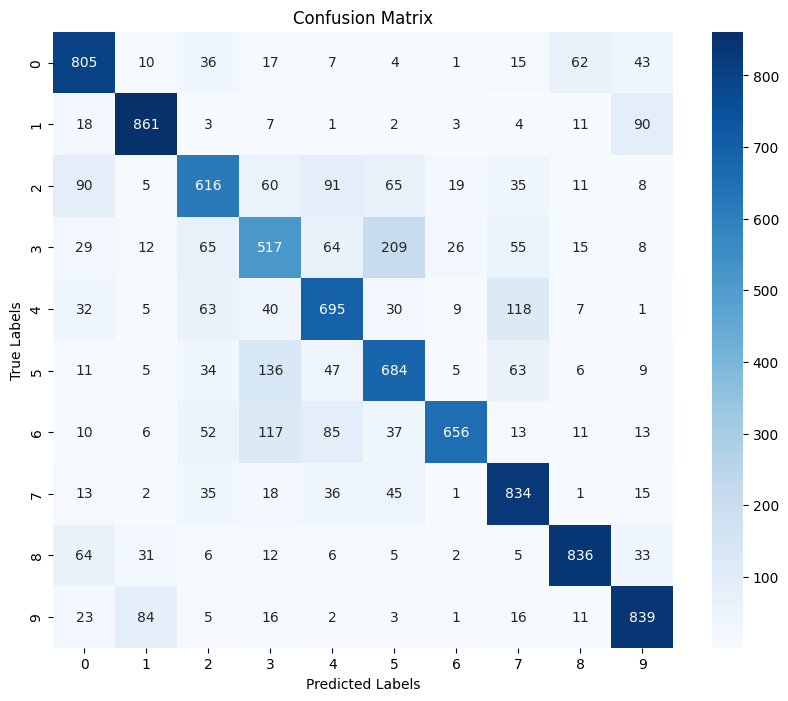

Classification Report:
              precision    recall  f1-score   support

    airplane       0.74      0.81      0.77      1000
  automobile       0.84      0.86      0.85      1000
        bird       0.67      0.62      0.64      1000
         cat       0.55      0.52      0.53      1000
        deer       0.67      0.69      0.68      1000
         dog       0.63      0.68      0.66      1000
        frog       0.91      0.66      0.76      1000
       horse       0.72      0.83      0.77      1000
        ship       0.86      0.84      0.85      1000
       truck       0.79      0.84      0.81      1000

    accuracy                           0.73     10000
   macro avg       0.74      0.73      0.73     10000
weighted avg       0.74      0.73      0.73     10000



In [ ]:
# Get predictions on the test set
test_predictions = model.predict(test_dataset)
predicted_classes = np.argmax(test_predictions, axis=1)

# Get true labels from the test dataset
true_labels = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_classes, target_names=[
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


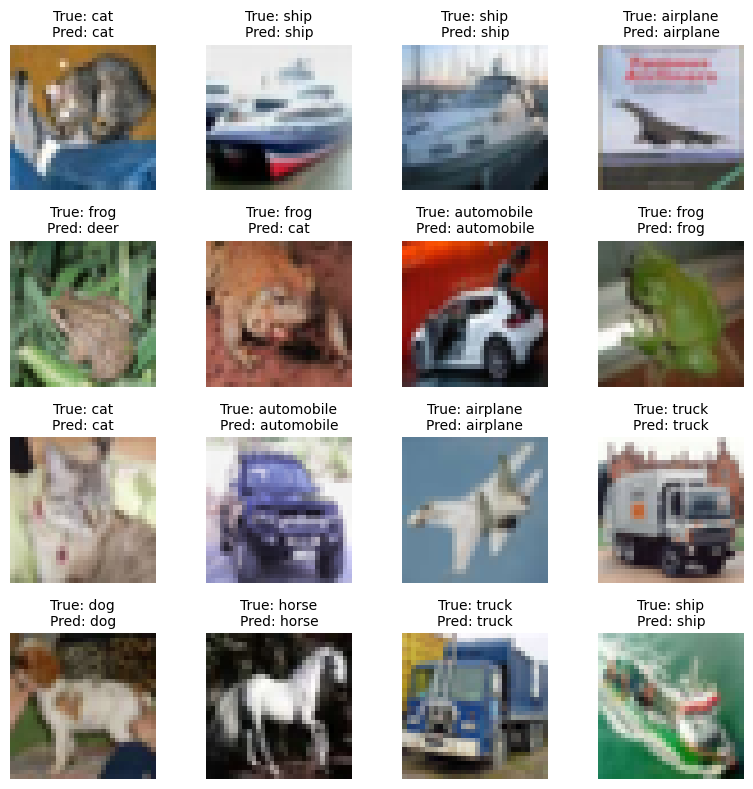

In [ ]:
# Define class names for CIFAR-10
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of test images and labels
test_images_batch, test_labels_batch = next(iter(test_dataset.unbatch().batch(16)))

# Get model predictions for this batch
predictions = model.predict(test_images_batch)
predicted_classes = np.argmax(predictions, axis=1)

# Plot some test images with their true and predicted labels
plt.figure(figsize=(8, 8))
for i in range(16):  # Display 16 images
    plt.subplot(4, 4, i + 1)
    plt.imshow(test_images_batch[i].numpy())

    # Convert labels to scalars
    true_label = class_names[test_labels_batch[i].numpy().item()]  # Extract scalar
    predicted_label = class_names[predicted_classes[i]]

    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()




## **Model 2: CNN Model using Pytorch**


In [ ]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Data transformations for CIFAR-10
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize with CIFAR-10 stats
])


In [ ]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training data into training and validation sets (90% train, 10% validation)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Data loaders
BATCH_SIZE = 128
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

# Load pre-trained ResNet18 and modify for CIFAR-10
model = models.resnet18(pretrained=True)  # Load pre-trained ResNet18
model.fc = nn.Linear(model.fc.in_features, 10)  # Replace the final layer for CIFAR-10 (10 classes)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [ ]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print epoch metrics
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")


Epoch 1/10, Train Loss: 0.9205, Train Accuracy: 68.87%, Val Loss: 0.7074, Val Accuracy: 75.28%
Epoch 2/10, Train Loss: 0.5899, Train Accuracy: 80.19%, Val Loss: 0.6332, Val Accuracy: 78.78%
Epoch 3/10, Train Loss: 0.4553, Train Accuracy: 84.80%, Val Loss: 0.5682, Val Accuracy: 80.46%
Epoch 4/10, Train Loss: 0.3623, Train Accuracy: 87.54%, Val Loss: 0.6749, Val Accuracy: 79.06%
Epoch 5/10, Train Loss: 0.2878, Train Accuracy: 90.34%, Val Loss: 0.6610, Val Accuracy: 79.18%
Epoch 6/10, Train Loss: 0.2244, Train Accuracy: 92.47%, Val Loss: 0.6631, Val Accuracy: 79.42%
Epoch 7/10, Train Loss: 0.1813, Train Accuracy: 93.87%, Val Loss: 0.6918, Val Accuracy: 80.32%
Epoch 8/10, Train Loss: 0.1499, Train Accuracy: 94.99%, Val Loss: 0.7147, Val Accuracy: 80.90%
Epoch 9/10, Train Loss: 0.1266, Train Accuracy: 95.63%, Val Loss: 0.7249, Val Accuracy: 80.60%
Epoch 10/10, Train Loss: 0.1099, Train Accuracy: 96.14%, Val Loss: 0.7583, Val Accuracy: 81.06%


In [ ]:
# Print epoch metrics in the desired format
print(f"{len(train_loader)}/{len(train_loader)} - {int(1000 / len(train_loader))}ms/step - accuracy: {train_accuracy:.3f} - loss: {train_loss:.4f}")
print(f"{len(val_loader)}/{len(val_loader)} - {int(1000 / len(val_loader))}ms/step - accuracy: {val_accuracy:.3f} - loss: {val_loss:.4f}")
print(f"Epoch {epoch + 1}/{num_epochs}, Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f}")


# Evaluation on test dataset
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

352/352 - 2ms/step - accuracy: 96.140 - loss: 0.1099
40/40 - 25ms/step - accuracy: 81.060 - loss: 0.7583
Epoch 10/10, Train Accuracy: 96.140, Val Accuracy: 81.060
Test Accuracy: 79.89%


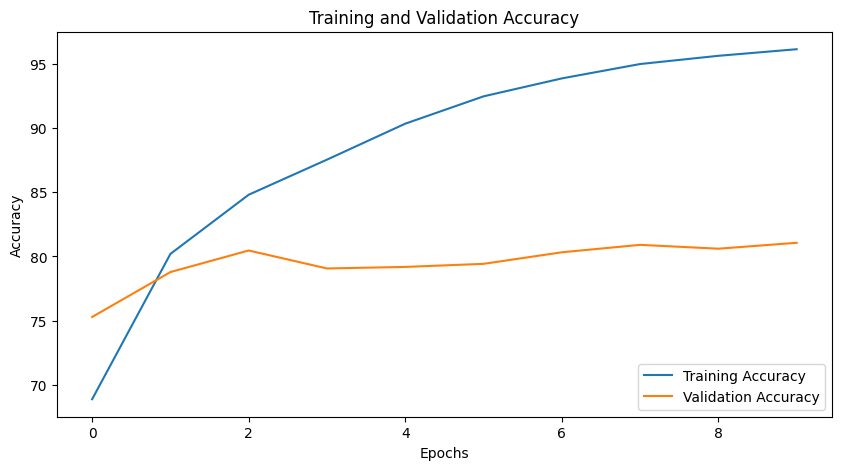

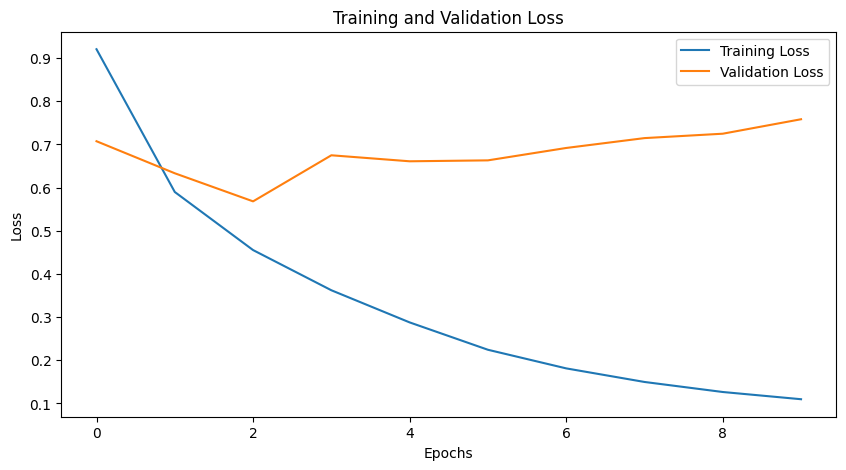

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Confusion Matrix:
[[843  21  46  25   7  10   8   7  16  17]
 [ 12 895   5   8   1  11   4   2  10  52]
 [ 34   2 758  65  57  37  26  13   3   5]
 [ 14   5  60 702  22 134  35  21   2   5]
 [ 15   3  36  89 745  32  17  55   5   3]
 [  6   3  33 185  26 697  18  29   1   2]
 [  7   4  39  74  17  18 836   3   1   1]
 [ 11   2  18  55  17  34   7 846   3   7]
 [ 75  42   9  25   4   9   4   1 807  24]
 [ 19  54   8  22   2   9   5   6  15 860]]


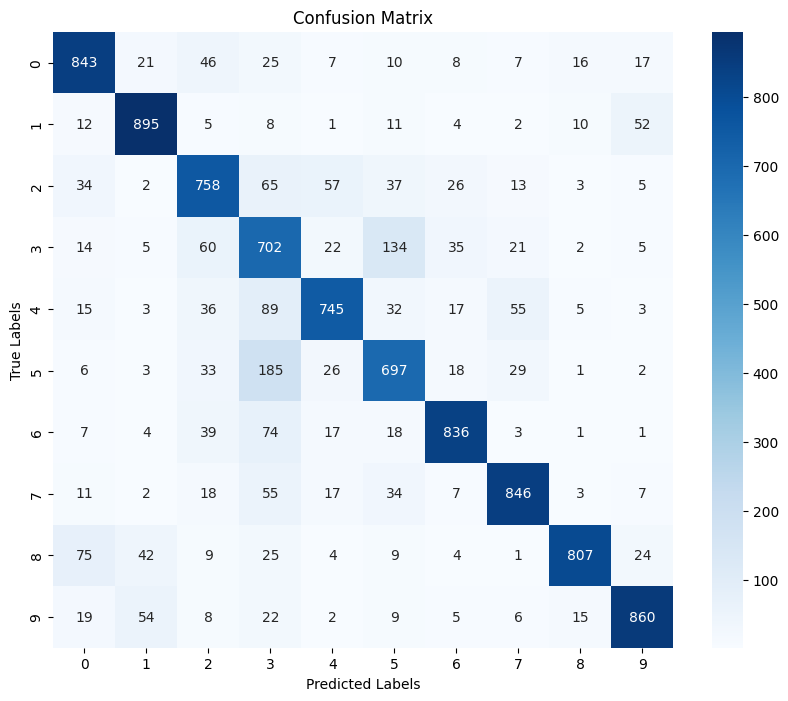

Classification Report:
              precision    recall  f1-score   support

    airplane       0.81      0.84      0.83      1000
  automobile       0.87      0.90      0.88      1000
        bird       0.75      0.76      0.75      1000
         cat       0.56      0.70      0.62      1000
        deer       0.83      0.74      0.79      1000
         dog       0.70      0.70      0.70      1000
        frog       0.87      0.84      0.85      1000
       horse       0.86      0.85      0.85      1000
        ship       0.94      0.81      0.87      1000
       truck       0.88      0.86      0.87      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.80      0.80     10000
weighted avg       0.81      0.80      0.80     10000



In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store predictions and true labels
all_predictions = []
all_true_labels = []

# Collect predictions and true labels
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Calculate confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification report
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
print("Classification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=class_names))

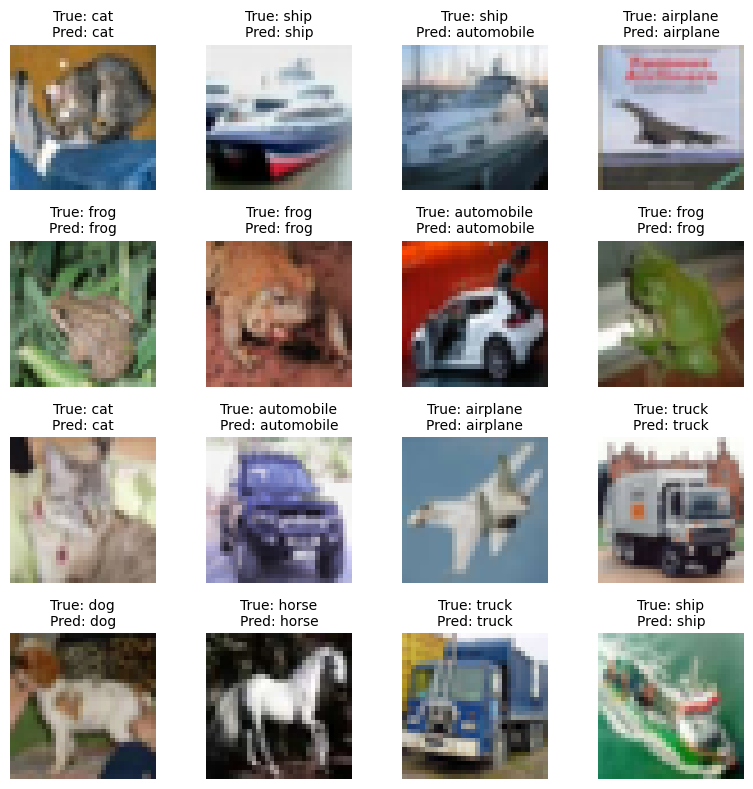

In [ ]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Get a batch of test images and labels
data_iter = iter(test_loader)
test_images_batch, test_labels_batch = next(data_iter)

# Move the images to the device (GPU/CPU)
test_images_batch = test_images_batch.to(device)

# Get model predictions for the batch
model.eval()
with torch.no_grad():
    outputs = model(test_images_batch)
    predicted_classes = torch.argmax(outputs, dim=1)

# Convert images and labels to CPU for visualization
test_images_batch = test_images_batch.cpu()
test_labels_batch = test_labels_batch.cpu()
predicted_classes = predicted_classes.cpu()

# Plot the test images with their true and predicted labels
plt.figure(figsize=(8, 8))
for i in range(16):  # Display 16 images
    plt.subplot(4, 4, i + 1)
    image = test_images_batch[i].permute(1, 2, 0)  # Convert from CHW to HWC format
    image = (image * 0.5 + 0.5).numpy()  # Denormalize the image
    plt.imshow(image)

    # Convert labels to class names
    true_label = class_names[test_labels_batch[i].item()]
    predicted_label = class_names[predicted_classes[i].item()]

    plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
class_accuracies = {}
for i, class_name in enumerate(class_names):
    class_correct = (all_predictions[all_true_labels == i] == i).sum()
    class_total = (all_true_labels == i).sum()
    class_accuracy = 100 * class_correct / class_total
    class_accuracies[class_name] = class_accuracy
    print(f"Accuracy for {class_name}: {class_accuracy:.2f}%")


Accuracy for airplane: 84.30%
Accuracy for automobile: 89.50%
Accuracy for bird: 75.80%
Accuracy for cat: 70.20%
Accuracy for deer: 74.50%
Accuracy for dog: 69.70%
Accuracy for frog: 83.60%
Accuracy for horse: 84.60%
Accuracy for ship: 80.70%
Accuracy for truck: 86.00%
